<a href="https://colab.research.google.com/github/dietadestina/AI4Jobs_program/blob/main/Deep_Learning_for_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center>Deep Learning for Time Series Forecasting</center></h2>

<img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Store%20Item%20Demand%20Forecasting%20Challenge/time-series%20graph.png" width="800">

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, SimpleRNN, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Loading data

In [2]:
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')
ev_sales

,Cat,Maker,Year,Value
0,1,1101,2015,0.000000
1,1,0,2015,0.000000
2,0,1,2015,0.000000
3,1,1,2015,0.000000
4,1,2,2015,0.000000
...,...,...,...,...
13395,0,1173,2024,0.000462
13396,0,1174,2024,0.000308
13397,0,1175,2024,0.002772
13398,0,1176,2024,0.000257


In [3]:
train, test = train_test_split(ev_sales, test_size=0.2, random_state=42)

### Train set

In [4]:
train.describe()

,Cat,Maker,Year,Value
count,10720.000000,10720.000000,10720.000000,10720.000000
mean,1.014272,583.503451,2019.509235,0.017576
std,0.645104,337.536666,2.876425,0.073818
min,0.000000,0.000000,2015.000000,0.000000
25%,1.000000,292.000000,2017.000000,0.000000
50%,1.000000,583.000000,2020.000000,0.000000
75%,1.000000,872.000000,2022.000000,0.001355
max,3.000000,1177.000000,2024.000000,1.000000


In [5]:
test.describe()

,Cat,Maker,Year,Value
count,2680.000000,2680.000000,2680.000000,2680.000000
mean,1.021269,582.183955,2019.463060,0.016935
std,0.636629,340.189138,2.856421,0.071468
min,0.000000,1.000000,2015.000000,0.000000
25%,1.000000,289.000000,2017.000000,0.000000
50%,1.000000,592.500000,2019.000000,0.000000
75%,1.000000,870.000000,2022.000000,0.001340
max,3.000000,1177.000000,2024.000000,1.000000


In [6]:
train.head()

,Cat,Maker,Year,Value
1472,2,111,2016,0.000000
9546,1,141,2022,0.000533
7318,1,542,2020,0.048780
5144,0,981,2018,0.000000
9148,1,965,2021,0.000000


### Time period of the train dataset

In [7]:
print('Min Year from train set:', train['Year'].min())
print('Max Year from train set:', train['Year'].max())

Min Year from train set: 2015
Max Year from train set: 2024


#### Let's find out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)

In [8]:
lag_size = (test['Year'].max() - train['Year'].max())
print('Max Year from train set:', train['Year'].max())
print('Max Year from test set:', test['Year'].max())
print('Forecast lag size (in years):', lag_size)

Max Year from train set: 2024
Max Year from test set: 2024
Forecast lag size (in years): 0


### Basic EDA

To explore the time series data first we need to aggregate the sales by day

In [9]:
yearly_sales = train.groupby('Year', as_index=False)['Value'].sum()
print(yearly_sales)
cat_yearly_sales = train.groupby(['Cat', 'Year'], as_index=False)['Value'].sum()
print(cat_yearly_sales)
maker_yearly_sales = train.groupby(['Maker', 'Year'], as_index=False)['Value'].sum()
print(maker_yearly_sales)

   Year      Value
0  2015   6.893258
1  2016  12.655308
2  2017  27.378299
3  2018  32.163755
4  2019  28.014016
5  2020  22.741192
6  2021  16.707440
7  2022  14.261158
8  2023  14.325681
9  2024  13.273731
    Cat  Year      Value
0     0  2015   3.977528
1     0  2016   0.963303
2     0  2017   0.278592
3     0  2018   0.161572
4     0  2019   0.232884
5     0  2020   0.767615
6     0  2021   2.724254
7     0  2022   3.672658
8     0  2023   3.851612
9     0  2024   3.822938
10    1  2015   2.095506
11    1  2016  11.457405
12    1  2017  25.980450
13    1  2018  31.348617
14    1  2019  27.405930
15    1  2020  21.780488
16    1  2021  13.148802
17    1  2022  10.135796
18    1  2023   9.841090
19    1  2024   8.903794
20    2  2015   0.786517
21    2  2016   0.229358
22    2  2017   1.115347
23    2  2018   0.646288
24    2  2019   0.305121
25    2  2020   0.188347
26    2  2021   0.781000
27    2  2022   0.451333
28    2  2023   0.620753
29    2  2024   0.545254
30    3  2015   

### Overall yearly sales

In [10]:
yearly_sales_sc = go.Scatter(x=yearly_sales['Year'], y=yearly_sales['Value'], mode='lines+markers')
layout = go.Layout(title='Yearly Sales', xaxis=dict(title='Year'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[yearly_sales_sc], layout=layout)
iplot(fig)

### Daily sales by store

In [11]:
store_yearly_sales_sc = []
for maker in maker_yearly_sales['Maker'].unique():
    current_maker_yearly_sales = maker_yearly_sales[maker_yearly_sales['Maker'] == maker]
    store_yearly_sales_sc.append(go.Scatter(x=current_maker_yearly_sales['Year'], y=current_maker_yearly_sales['Value'], name=('Maker %s' % maker)))

layout = go.Layout(title='Yearly Sales per Maker', xaxis=dict(title='Year'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_yearly_sales_sc, layout=layout)
iplot(fig)

### Daily sales by item

In [12]:
cat_yearly_sales_sc = []
for cat in cat_yearly_sales['Cat'].unique():
    current_cat_yearly_sales = cat_yearly_sales[cat_yearly_sales['Cat'] == cat]
    cat_yearly_sales_sc.append(go.Scatter(x=current_cat_yearly_sales['Year'], y=current_cat_yearly_sales['Value'], name=('Cat %s' % cat)))

layout = go.Layout(title='Yearly Sales per Category', xaxis=dict(title='Year'), yaxis=dict(title='Sales'))
fig = go.Figure(data=cat_yearly_sales_sc, layout=layout)
iplot(fig)

#### Sub-sample train set to get only the last year of data and reduce training time

### Rearrange dataset so we can apply shift methods

In [13]:
train_gp = train.groupby(['Maker', 'Cat', 'Year'], as_index=False).agg({'Value': 'mean'})
train_gp.columns = ['Maker', 'Cat', 'Year', 'Value']
train_gp.head()

,Maker,Cat,Year,Value
0,0,1,2015,0.0
1,0,1,2016,0.0
2,0,1,2017,0.0
3,0,1,2018,0.0
4,0,1,2019,0.0


### Transform the data into a time series problem

In [14]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

df_supervised = series_to_supervised(ev_sales[['Year', 'Value']], window=1, lag=1)
print(df_supervised)

       Year(t-1)  Value(t-1)  Year(t)  Value(t)  Year(t+1)  Value(t+1)
1         2015.0    0.000000     2015  0.000000     2015.0    0.000000
2         2015.0    0.000000     2015  0.000000     2015.0    0.000000
3         2015.0    0.000000     2015  0.000000     2015.0    0.000000
4         2015.0    0.000000     2015  0.000000     2015.0    0.000000
5         2015.0    0.000000     2015  0.000000     2015.0    0.000000
...          ...         ...      ...       ...        ...         ...
13394     2024.0    0.002824     2024  0.000975     2024.0    0.000462
13395     2024.0    0.000975     2024  0.000462     2024.0    0.000308
13396     2024.0    0.000462     2024  0.000308     2024.0    0.002772
13397     2024.0    0.000308     2024  0.002772     2024.0    0.000257
13398     2024.0    0.002772     2024  0.000257     2024.0    0.003799

[13398 rows x 6 columns]


#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [15]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('Year', axis=1), window=window, lag=lag)
print(series.head())

    Maker(t-29)  Cat(t-29)  Value(t-29)  Maker(t-28)  Cat(t-28)  Value(t-28)  \
29          0.0        1.0          0.0          0.0        1.0          0.0   
30          0.0        1.0          0.0          0.0        1.0          0.0   
31          0.0        1.0          0.0          0.0        1.0          0.0   
32          0.0        1.0          0.0          0.0        1.0          0.0   
33          0.0        1.0          0.0          0.0        1.0          0.0   

    Maker(t-27)  Cat(t-27)  Value(t-27)  Maker(t-26)  ...  Value(t-2)  \
29          0.0        1.0     0.000000          0.0  ...    0.000000   
30          0.0        1.0     0.000000          0.0  ...    0.000000   
31          0.0        1.0     0.000000          0.0  ...    0.000000   
32          0.0        1.0     0.000000          0.0  ...    0.044715   
33          0.0        1.0     0.023539          0.0  ...    0.009037   

    Maker(t-1)  Cat(t-1)  Value(t-1)  Maker(t)  Cat(t)  Value(t)  Maker(t+0)  \


#### Drop rows with different item or store values than the shifted columns

#### Remove unwanted columns

In [16]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Cat', 'Maker']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Cat', 'Maker']]

# Drop the unnecessary columns
series.drop(columns_to_drop, axis=1, inplace=True)

# Drop 'Cat(t)' and 'Maker(t)' for the current timestep
series.drop(['Cat(t)', 'Maker(t)'], axis=1, inplace=True)

### Train/validation split

In [17]:
# Label
labels_col = 'Value(t+%d)' % lag
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

# Splitting the data into train and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)

print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (6414, 30)
Validation set shape (4277, 30)


,Value(t-29),Value(t-28),Value(t-27),Value(t-26),Value(t-25),Value(t-24),Value(t-23),Value(t-22),Value(t-21),Value(t-20),...,Value(t-9),Value(t-8),Value(t-7),Value(t-6),Value(t-5),Value(t-4),Value(t-3),Value(t-2),Value(t-1),Value(t)
9447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000539,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.001355,0.002371,0.006160,0.000000,0.000000,0.000000
2107,0.056664,0.042670,0.005618,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000457,0.000051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4130,0.000719,0.005618,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.002437,0.002121,0.000667,0.000000,0.000000,0.012373,0.003235
3614,0.000000,0.000978,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065494,0.216157,...,0.0,0.0,0.000083,0.000205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9591,0.391874,0.422853,0.205962,0.104876,0.101393,0.090354,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.010647,0.003542,0.000000,0.003932,0.022483,0.091703,0.022102,0.001355


In [18]:
epochs = 10
batch = 32

In [19]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (6414, 30, 1)
Validation set shape (4277, 30, 1)


### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [20]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           3,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/10
201/201 - 7s - 35ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 2/10
201/201 - 1s - 4ms/step - loss: 7.5608e-04 - val_loss: 5.3907e-04
Epoch 3/10
201/201 - 1s - 5ms/step - loss: 3.5595e-04 - val_loss: 2.9696e-04
Epoch 4/10
201/201 - 1s - 4ms/step - loss: 2.0895e-04 - val_loss: 1.9367e-04
Epoch 5/10
201/201 - 0s - 2ms/step - loss: 1.4152e-04 - val_loss: 1.4328e-04
Epoch 6/10
201/201 - 0s - 2ms/step - loss: 1.0416e-04 - val_loss: 1.1946e-04
Epoch 7/10
201/201 - 1s - 3ms/step - loss: 8.2716e-05 - val_loss: 9.8300e-05
Epoch 8/10
201/201 - 1s - 3ms/step - loss: 6.5124e-05 - val_loss: 9.4412e-05
Epoch 9/10
201/201 - 1s - 3ms/step - loss: 5.6797e-05 - val_loss: 7.8503e-05
Epoch 10/10
201/201 - 1s - 4ms/step - loss: 4.7501e-05 - val_loss: 7.4091e-05


### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [22]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))

model_cnn.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 29, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          44,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,093 (176.14 KB)

 Trainable params: 45,093 (176.14 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/10
201/201 - 6s - 30ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 2/10
201/201 - 1s - 5ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 3/10
201/201 - 1s - 7ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 4/10
201/201 - 1s - 4ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 5/10
201/201 - 1s - 4ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 6/10
201/201 - 1s - 4ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 7/10
201/201 - 1s - 6ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 8/10
201/201 - 1s - 6ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 9/10
201/201 - 1s - 3ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 10/10
201/201 - 0s - 2ms/step - loss: 0.0033 - val_loss: 0.0039


### RNN for Time Series Forecasting

In [24]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_rnn.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_rnn.compile(loss='mse', optimizer=adam)
model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
rnn_history = model_rnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/10
201/201 - 6s - 28ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 2/10
201/201 - 2s - 10ms/step - loss: 6.4231e-04 - val_loss: 2.1050e-04
Epoch 3/10
201/201 - 1s - 5ms/step - loss: 9.6018e-05 - val_loss: 1.8959e-05
Epoch 4/10
201/201 - 1s - 5ms/step - loss: 1.8929e-05 - val_loss: 1.4894e-05
Epoch 5/10
201/201 - 1s - 5ms/step - loss: 8.9211e-06 - val_loss: 7.2483e-06
Epoch 6/10
201/201 - 1s - 5ms/step - loss: 5.9848e-06 - val_loss: 4.6541e-06
Epoch 7/10
201/201 - 1s - 6ms/step - loss: 5.3052e-06 - val_loss: 5.1305e-06
Epoch 8/10
201/201 - 1s - 6ms/step - loss: 3.9536e-06 - val_loss: 3.0719e-06
Epoch 9/10
201/201 - 1s - 7ms/step - loss: 3.4261e-06 - val_loss: 2.5075e-06
Epoch 10/10
201/201 - 2s - 12ms/step - loss: 3.8854e-06 - val_loss: 2.6947e-06


### LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
adam = optimizers.Adam(0.0003)
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/10
201/201 - 5s - 22ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 2/10
201/201 - 1s - 6ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/10
201/201 - 1s - 5ms/step - loss: 0.0013 - val_loss: 9.7501e-04
Epoch 4/10
201/201 - 1s - 5ms/step - loss: 5.4040e-04 - val_loss: 3.1798e-04
Epoch 5/10
201/201 - 1s - 7ms/step - loss: 2.6005e-04 - val_loss: 1.2916e-04
Epoch 6/10
201/201 - 1s - 6ms/step - loss: 1.4029e-04 - val_loss: 8.1443e-05
Epoch 7/10
201/201 - 1s - 6ms/step - loss: 5.6349e-05 - val_loss: 2.2783e-05
Epoch 8/10
201/201 - 1s - 6ms/step - loss: 3.8262e-05 - val_loss: 1.8725e-05
Epoch 9/10
201/201 - 1s - 6ms/step - loss: 1.6225e-05 - val_loss: 1.6478e-05
Epoch 10/10
201/201 - 1s - 5ms/step - loss: 2.1099e-05 - val_loss: 6.3677e-05


### Comparing models

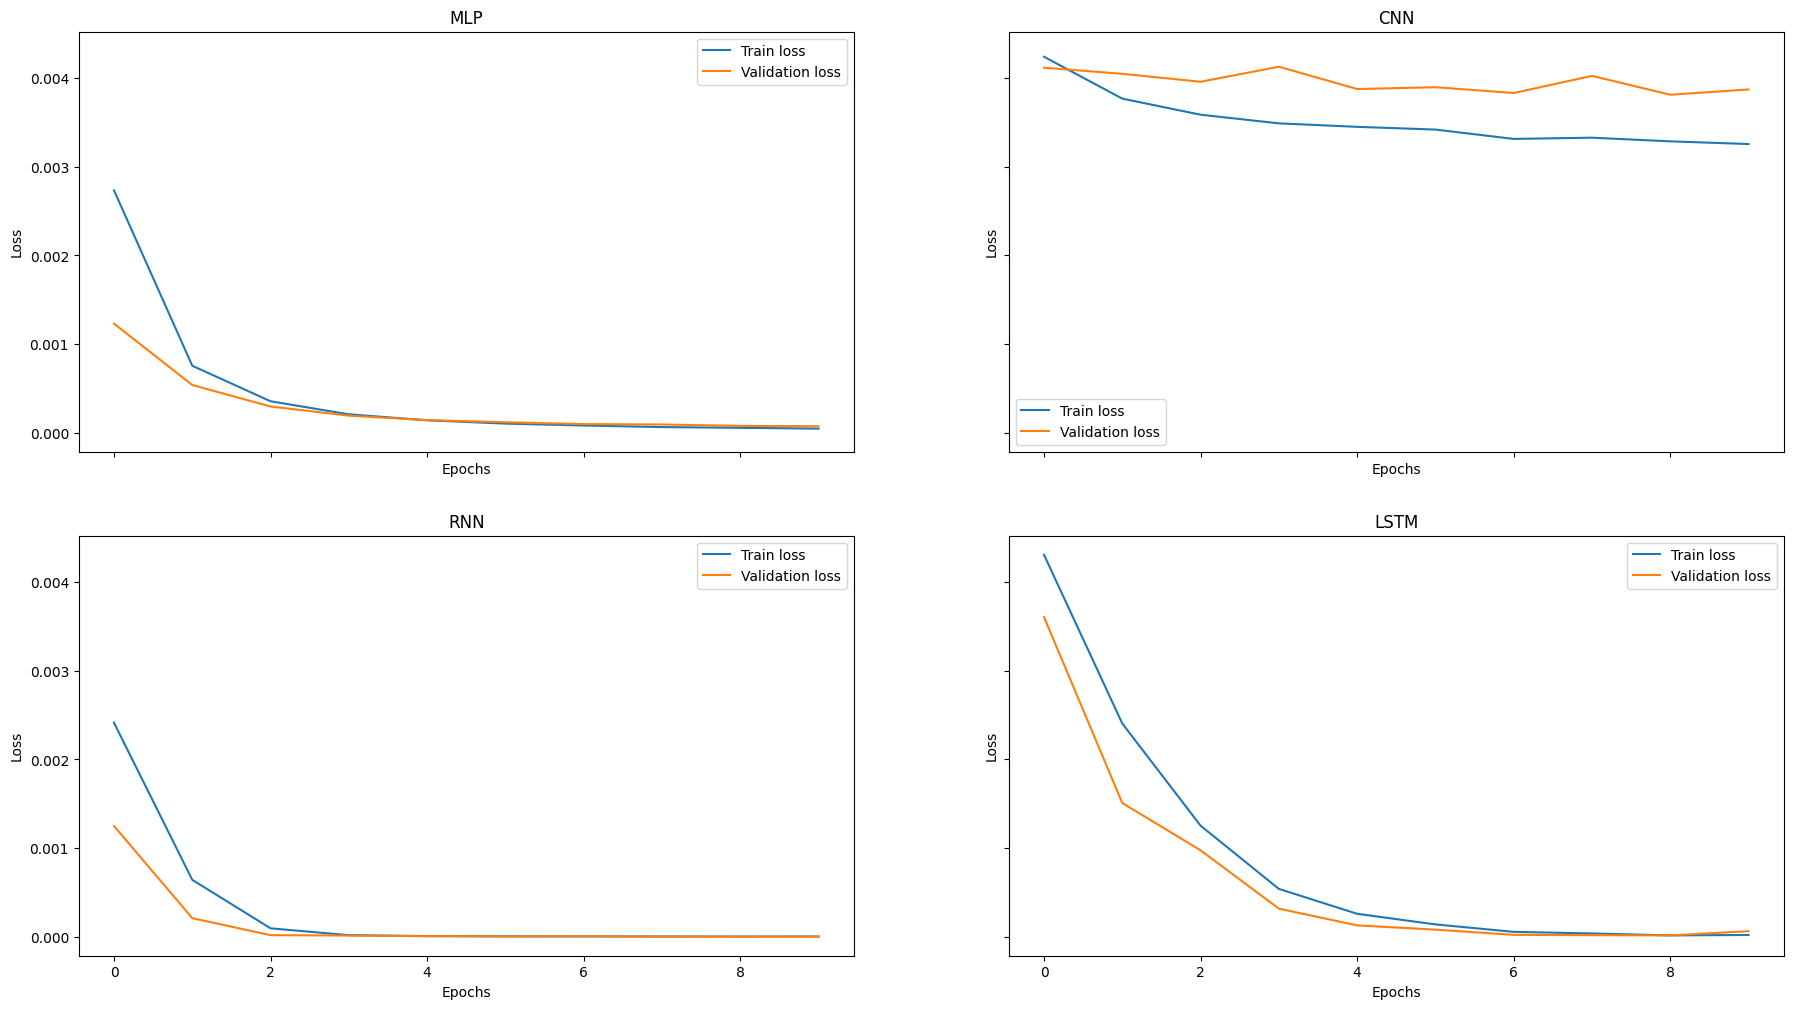

In [28]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(rnn_history.history['loss'], label='Train loss')
ax3.plot(rnn_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('RNN')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')

ax4.plot(lstm_history.history['loss'], label='Train loss')
ax4.plot(lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')

plt.show()